In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display
import os
import seaborn as sb
import shutil
import soundfile as sf
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

The **ESC-50 dataset** is a labeled collection of 2000 environmental audio recordings suitable for benchmarking methods of environmental sound classification.

The dataset consists of 5-second-long recordings organized into 50 semantical classes (with 40 examples per class) loosely arranged into 5 major categories:

| <sub>Animals</sub> | <sub>Natural soundscapes & water sounds </sub> | <sub>Human, non-speech sounds</sub> | <sub>Interior/domestic sounds</sub> | <sub>Exterior/urban noises</sub> |
| :--- | :--- | :--- | :--- | :--- |
| <sub>Dog</sub> | <sub>Rain</sub> | <sub>Crying baby</sub> | <sub>Door knock</sub> | <sub>Helicopter</sub></sub> |
| <sub>Rooster</sub> | <sub>Sea waves</sub> | <sub>Sneezing</sub> | <sub>Mouse click</sub> | <sub>Chainsaw</sub> |
| <sub>Pig</sub> | <sub>Crackling fire</sub> | <sub>Clapping</sub> | <sub>Keyboard typing</sub> | <sub>Siren</sub> |
| <sub>Cow</sub> | <sub>Crickets</sub> | <sub>Breathing</sub> | <sub>Door, wood creaks</sub> | <sub>Car horn</sub> |
| <sub>Frog</sub> | <sub>Chirping birds</sub> | <sub>Coughing</sub> | <sub>Can opening</sub> | <sub>Engine</sub> |
| <sub>Cat</sub> | <sub>Water drops</sub> | <sub>Footsteps</sub> | <sub>Washing machine</sub> | <sub>Train</sub> |
| <sub>Hen</sub> | <sub>Wind</sub> | <sub>Laughing</sub> | <sub>Vacuum cleaner</sub> | <sub>Church bells</sub> |
| <sub>Insects (flying)</sub> | <sub>Pouring water</sub> | <sub>Brushing teeth</sub> | <sub>Clock alarm</sub> | <sub>Airplane</sub> |
| <sub>Sheep</sub> | <sub>Toilet flush</sub> | <sub>Snoring</sub> | <sub>Clock tick</sub> | <sub>Fireworks</sub> |
| <sub>Crow</sub> | <sub>Thunderstorm</sub> | <sub>Drinking, sipping</sub> | <sub>Glass breaking</sub> | <sub>Hand saw</sub> |

In [59]:
metadata = pd.read_csv('ESC-50-master/meta/esc50.csv')

metadata.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [60]:
metadata = metadata[['category','filename']].copy()

metadata.head()

,category,filename
0,dog,1-100032-A-0.wav
1,chirping_birds,1-100038-A-14.wav
2,vacuum_cleaner,1-100210-A-36.wav
3,vacuum_cleaner,1-100210-B-36.wav
4,thunderstorm,1-101296-A-19.wav


In [61]:
metadata['category'].unique()

array(['dog', 'chirping_birds', 'vacuum_cleaner', 'thunderstorm',
       'door_wood_knock', 'can_opening', 'crow', 'clapping', 'fireworks',
       'chainsaw', 'airplane', 'mouse_click', 'pouring_water', 'train',
       'sheep', 'water_drops', 'church_bells', 'clock_alarm',
       'keyboard_typing', 'wind', 'footsteps', 'frog', 'cow',
       'brushing_teeth', 'car_horn', 'crackling_fire', 'helicopter',
       'drinking_sipping', 'rain', 'insects', 'laughing', 'hen', 'engine',
       'breathing', 'crying_baby', 'hand_saw', 'coughing',
       'glass_breaking', 'snoring', 'toilet_flush', 'pig',
       'washing_machine', 'clock_tick', 'sneezing', 'rooster',
       'sea_waves', 'siren', 'cat', 'door_wood_creaks', 'crickets'],
      dtype=object)

In [62]:
metadata.shape

(2000, 2)

In [63]:
animal_categories = [
    'dog',
    'chirping_birds',
    'crow','sheep',
    'frog',
    'cow',
    'insects',
    'hen',
    'pig',
    'rooster',
    'cat'
]

# animal_metadata = metadata[metadata['category'].isin(animal_categories)]

# animal_metadata['category'].unique()




create folder if does not exist

In [64]:
folder_path = 'cleaned_audio'
clean_data_file_path = 'cleaned_metadata.csv'
skip_delete = os.path.exists(clean_data_file_path)

# Check if the folder does not exist
if not os.path.exists(folder_path):
    # Create the folder
    os.makedirs(folder_path)
    result = f"Folder '{folder_path}' was created."
else:
    # If skip_delete is False, delete everything in the folder
    if not skip_delete:
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.pcleath.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                result = f'Failed to delete {file_path}. Reason: {e}'
        result = f"Existing contents of '{folder_path}' have been deleted."
    else:
        result = "Skipping deletion as per 'skip_delete' flag."

result



"Skipping deletion as per 'skip_delete' flag."

In [65]:
source_directory = 'ESC-50-master/audio'

def adjust_volume(data, volume_change):
    return data * volume_change

if not skip_delete:
    for index, row in metadata.iterrows():
        filename = row['filename']
        category = row['category']

        #Copy original file over
        source_file = os.path.join(source_directory, filename)
        destination_file = os.path.join(folder_path, filename)
        shutil.copy2(source_file, destination_file)

        try:
            y, sr = librosa.load(source_file, sr=None)

            #Adjust volumes
            y_higher = adjust_volume(y,2)
            y_lower = adjust_volume(y,0.5)

            #Generate new filenames
            base, ext = os.path.splitext(filename)
            higher_volume_filename = f"{base}_higher{ext}"
            lower_volume_filename = f"{base}_lower{ext}"

            #Save the adjusted audio files
            higher_file_path = os.path.join(folder_path, higher_volume_filename)
            lower_file_path = os.path.join(folder_path, lower_volume_filename)
            sf.write(higher_file_path, y_higher, sr)
            sf.write(lower_file_path, y_lower, sr)

            # Add new entries to the dataframe
            new_rows = [
                {'category': category, 'filename': higher_volume_filename},
                {'category': category, 'filename': lower_volume_filename}
            ]
            metadata = pd.concat([metadata, pd.DataFrame(new_rows)], ignore_index=True)

        except Exception as e:
            print(f"Error processing file {filename}: {e}")

        result = "Files copied successfully."
else:
    result = "Skipping file copying and manipulation as per 'skip_delete' flag."

result

"Skipping file copying and manipulation as per 'skip_delete' flag."

In [66]:
metadata.shape

(2000, 2)

# Animal Sound Classification Features Overview (NEED TO MOVE THIS)

## 1. Mel-frequency Cepstral Coefficients (MFCCs)
- **Why?** MFCCs are very effective in capturing the timbral aspects of sound. They've been widely used in speech recognition and can differentiate various types of sounds including animal vocalizations. The coefficients effectively capture the rate changes in spectral bands and are useful for identifying different kinds of animal sounds.

## 2. Spectral Features
- **Spectral Centroid:** Useful for identifying the "brightness" of a sound, which can differentiate between high-pitched and low-pitched animal calls.
- **Spectral Bandwidth:** Provides information about the spread of the spectrum, which can help distinguish between broad and narrow-band sounds.
- **Spectral Contrast:** Useful for identifying different sound textures and can help differentiate between sounds in different environments or contexts.
- **Spectral Rolloff:** Indicates the frequency below which a certain percentage of the total spectral energy is contained. It can be used to distinguish between harmonic (musical) and inharmonic sounds.

## 3. Chroma Features
- **Chroma STFT:** Captures the harmonic content of audio which might be useful for some species where the harmonic structure of the sound is important for classification.

## 4. Rhythm Features
- **Tempo:** While not always directly applicable to animal sounds, the tempo can be useful in contexts where the rhythm of sounds (like the repetitive calls of some species) plays a role in identification.

## 5. Zero-Crossing Rate (ZCR)
- **Why?** It measures the rate of sign changes along a signal. Useful for distinguishing between percussive sounds and more sustained sounds. Animal calls often have distinctive patterns that can be captured by ZCR.

## 6. Root Mean Square (RMS) Energy
- **Why?** It provides a measure of the sound's energy over time. For animal sound classification, variations in energy can help differentiate between vocalizations.

## 7. Time-domain Features
- Although less common than frequency-domain features for this type of classification, features like waveform shape and amplitude envelope could provide useful insights into the dynamics of animal vocalizations.


In [67]:
# Define the feature names with the new meaningful names
feature_names = (
['Spectral_Energy', 'Spectral_Shape_1', 'Spectral_Shape_2', 'Spectral_Shape_3',
    'Fine_Spectral_Texture_1', 'Fine_Spectral_Texture_2', 'Fine_Spectral_Texture_3',
    'Fine_Timbral_Detail_1', 'Fine_Timbral_Detail_2', 'Fine_Timbral_Detail_3',
    'Subtle_Timbral_Variation_1', 'Subtle_Timbral_Variation_2', 'Subtle_Timbral_Variation_3'] +
['Spectral_Centroid', 'Spectral_Bandwidth'] +
['Low_Frequency_Contrast', 'Mid_Low_Frequency_Contrast', 'Mid_Frequency_Contrast',
'Mid_High_Frequency_Contrast', 'High_Frequency_Contrast', 'Very_High_Frequency_Contrast',
'Extreme_High_Frequency_Contrast'] 
+
['Spectral_Rolloff'] +
['Chroma_C', 'Chroma_C#', 'Chroma_D', 'Chroma_D#', 'Chroma_E',
    'Chroma_F', 'Chroma_F#', 'Chroma_G', 'Chroma_G#', 'Chroma_A', 'Chroma_A#', 'Chroma_B'] +
['Zero_Crossing_Rate', 'RMS_Energy']
)

# Define the function to extract audio features
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
        spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr), axis=1)
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
        chroma_stft = np.mean(librosa.feature.chroma_stft(y=y, sr=sr), axis=1)
        zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y))
        rms_energy = np.mean(librosa.feature.rms(y=y))
        features = np.hstack((mfccs, spectral_centroid, spectral_bandwidth, spectral_contrast, spectral_rolloff, chroma_stft, zero_crossing_rate, rms_energy))
        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return [np.nan]*37  # Adjust for the total number of features

if os.path.exists(clean_data_file_path):
    metadata = pd.read_csv(clean_data_file_path)
else:
    # Prepare to collect the features
    features = []

    # Extract features for each audio file in the DataFrame
    for _, row in metadata.iterrows():
        filename = row['filename']
        source_file = os.path.join(folder_path, filename)
        try:
            features.append(extract_features(source_file))
        except Exception as e:
            print(f"Error processing {source_file}: {e}")
            features.append([np.nan]*37)  # Adjust for the total number of features

    # Convert the list of features to a DataFrame
    features_df = pd.DataFrame(features, columns=feature_names)

    # Concatenate with the original DataFrame (check alignment)
    metadata = pd.concat([metadata.reset_index(drop=True), features_df], axis=1)

    # Save the updated DataFrame to CSV
    metadata.to_csv(clean_data_file_path, index=False)

In [68]:
metadata = metadata.sort_values(by='filename')
metadata.head()

,category,filename,Spectral_Energy,Spectral_Shape_1,Spectral_Shape_2,Spectral_Shape_3,Fine_Spectral_Texture_1,Fine_Spectral_Texture_2,Fine_Spectral_Texture_3,Fine_Timbral_Detail_1,...,Chroma_E,Chroma_F,Chroma_F#,Chroma_G,Chroma_G#,Chroma_A,Chroma_A#,Chroma_B,Zero_Crossing_Rate,RMS_Energy
0,dog,1-100032-A-0.wav,-581.739929,8.207122,-6.658803,-4.290906,-3.034478,0.259279,-1.963946,-0.271577,...,0.015058,0.018501,0.017698,0.028559,0.063234,0.053491,0.022580,0.027154,0.007329,0.007518
2000,dog,1-100032-A-0_higher.wav,-513.559631,8.169988,-5.804877,-3.770867,-2.435952,0.241496,-1.235061,-0.285446,...,0.015134,0.018785,0.017654,0.025020,0.058404,0.059829,0.024756,0.025157,0.007329,0.014233
2001,dog,1-100032-A-0_lower.wav,-649.853699,8.209495,-6.656574,-4.288518,-3.032670,0.261461,-1.962061,-0.269821,...,0.014341,0.017798,0.017214,0.027870,0.062679,0.053323,0.022173,0.027311,0.007329,0.003759
1,chirping_birds,1-100038-A-14.wav,-254.936310,85.839622,-107.103157,31.011576,-39.987736,-17.290342,-37.214104,-18.145691,...,0.358096,0.370746,0.372750,0.455916,0.449673,0.240554,0.221091,0.203570,0.157994,0.048115
2002,chirping_birds,1-100038-A-14_higher.wav,-186.632996,85.752045,-106.850655,30.957167,-39.775810,-17.305708,-37.043076,-18.121487,...,0.358095,0.370746,0.372750,0.455918,0.449673,0.240554,0.221091,0.203570,0.157994,0.096224


In [69]:
metadata['is_animal'] = np.where(metadata['category'].isin(animal_categories), 1, 0)
metadata.head()

,category,filename,Spectral_Energy,Spectral_Shape_1,Spectral_Shape_2,Spectral_Shape_3,Fine_Spectral_Texture_1,Fine_Spectral_Texture_2,Fine_Spectral_Texture_3,Fine_Timbral_Detail_1,...,Chroma_F,Chroma_F#,Chroma_G,Chroma_G#,Chroma_A,Chroma_A#,Chroma_B,Zero_Crossing_Rate,RMS_Energy,is_animal
0,dog,1-100032-A-0.wav,-581.739929,8.207122,-6.658803,-4.290906,-3.034478,0.259279,-1.963946,-0.271577,...,0.018501,0.017698,0.028559,0.063234,0.053491,0.022580,0.027154,0.007329,0.007518,1
2000,dog,1-100032-A-0_higher.wav,-513.559631,8.169988,-5.804877,-3.770867,-2.435952,0.241496,-1.235061,-0.285446,...,0.018785,0.017654,0.025020,0.058404,0.059829,0.024756,0.025157,0.007329,0.014233,1
2001,dog,1-100032-A-0_lower.wav,-649.853699,8.209495,-6.656574,-4.288518,-3.032670,0.261461,-1.962061,-0.269821,...,0.017798,0.017214,0.027870,0.062679,0.053323,0.022173,0.027311,0.007329,0.003759,1
1,chirping_birds,1-100038-A-14.wav,-254.936310,85.839622,-107.103157,31.011576,-39.987736,-17.290342,-37.214104,-18.145691,...,0.370746,0.372750,0.455916,0.449673,0.240554,0.221091,0.203570,0.157994,0.048115,1
2002,chirping_birds,1-100038-A-14_higher.wav,-186.632996,85.752045,-106.850655,30.957167,-39.775810,-17.305708,-37.043076,-18.121487,...,0.370746,0.372750,0.455918,0.449673,0.240554,0.221091,0.203570,0.157994,0.096224,1


In [70]:
cleaned_metadata = metadata.drop(columns=['filename','category'])
cleaned_metadata.head()

,Spectral_Energy,Spectral_Shape_1,Spectral_Shape_2,Spectral_Shape_3,Fine_Spectral_Texture_1,Fine_Spectral_Texture_2,Fine_Spectral_Texture_3,Fine_Timbral_Detail_1,Fine_Timbral_Detail_2,Fine_Timbral_Detail_3,...,Chroma_F,Chroma_F#,Chroma_G,Chroma_G#,Chroma_A,Chroma_A#,Chroma_B,Zero_Crossing_Rate,RMS_Energy,is_animal
0,-581.739929,8.207122,-6.658803,-4.290906,-3.034478,0.259279,-1.963946,-0.271577,0.518284,0.341884,...,0.018501,0.017698,0.028559,0.063234,0.053491,0.022580,0.027154,0.007329,0.007518,1
2000,-513.559631,8.169988,-5.804877,-3.770867,-2.435952,0.241496,-1.235061,-0.285446,0.604016,0.566948,...,0.018785,0.017654,0.025020,0.058404,0.059829,0.024756,0.025157,0.007329,0.014233,1
2001,-649.853699,8.209495,-6.656574,-4.288518,-3.032670,0.261461,-1.962061,-0.269821,0.520418,0.343702,...,0.017798,0.017214,0.027870,0.062679,0.053323,0.022173,0.027311,0.007329,0.003759,1
1,-254.936310,85.839622,-107.103157,31.011576,-39.987736,-17.290342,-37.214104,-18.145691,-11.705071,-17.621454,...,0.370746,0.372750,0.455916,0.449673,0.240554,0.221091,0.203570,0.157994,0.048115,1
2002,-186.632996,85.752045,-106.850655,30.957167,-39.775810,-17.305708,-37.043076,-18.121487,-11.573458,-17.572086,...,0.370746,0.372750,0.455918,0.449673,0.240554,0.221091,0.203570,0.157994,0.096224,1


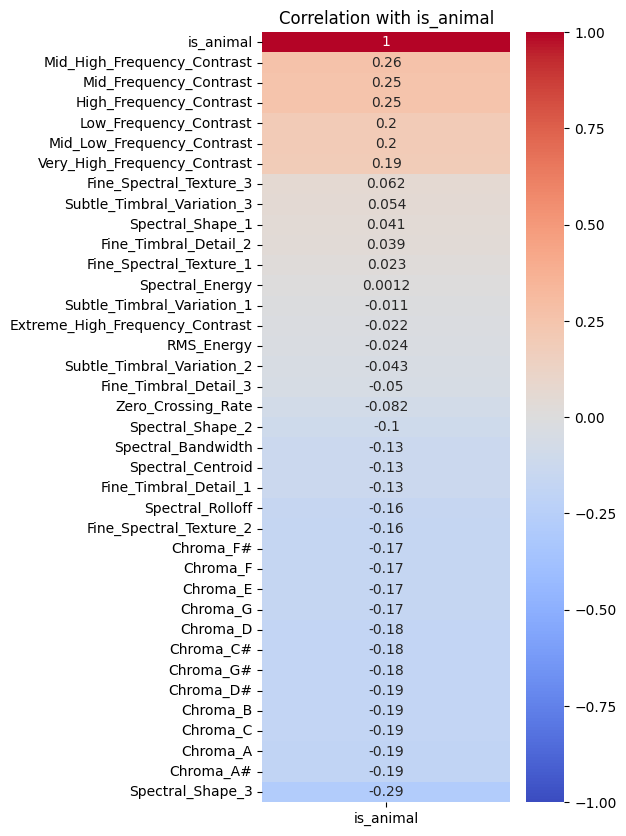

In [71]:
corr_matrix = cleaned_metadata.corr()

# Focus on the 'is_animal' correlations
corr_with_is_animal = corr_matrix[['is_animal']]

# Create a heatmap
plt.figure(figsize=(4, 10))  # Adjust the figure size as needed
sb.heatmap(corr_with_is_animal.sort_values(by='is_animal', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with is_animal')

# Show the plot
plt.show()

In [72]:
# Map categories to numerical values
category_mapping = {category: index + 1 for index, category in enumerate(animal_categories)}

# Add numerical values to the DataFrame
metadata['category_numeric'] = metadata['category'].map(category_mapping)

#remove the non-numerical columns
cleaned_metadata1 = metadata.drop(columns=['filename', 'category'])

cleaned_metadata1.head()

,Spectral_Energy,Spectral_Shape_1,Spectral_Shape_2,Spectral_Shape_3,Fine_Spectral_Texture_1,Fine_Spectral_Texture_2,Fine_Spectral_Texture_3,Fine_Timbral_Detail_1,Fine_Timbral_Detail_2,Fine_Timbral_Detail_3,...,Chroma_F#,Chroma_G,Chroma_G#,Chroma_A,Chroma_A#,Chroma_B,Zero_Crossing_Rate,RMS_Energy,is_animal,category_numeric
0,-581.739929,8.207122,-6.658803,-4.290906,-3.034478,0.259279,-1.963946,-0.271577,0.518284,0.341884,...,0.017698,0.028559,0.063234,0.053491,0.022580,0.027154,0.007329,0.007518,1,1.0
2000,-513.559631,8.169988,-5.804877,-3.770867,-2.435952,0.241496,-1.235061,-0.285446,0.604016,0.566948,...,0.017654,0.025020,0.058404,0.059829,0.024756,0.025157,0.007329,0.014233,1,1.0
2001,-649.853699,8.209495,-6.656574,-4.288518,-3.032670,0.261461,-1.962061,-0.269821,0.520418,0.343702,...,0.017214,0.027870,0.062679,0.053323,0.022173,0.027311,0.007329,0.003759,1,1.0
1,-254.936310,85.839622,-107.103157,31.011576,-39.987736,-17.290342,-37.214104,-18.145691,-11.705071,-17.621454,...,0.372750,0.455916,0.449673,0.240554,0.221091,0.203570,0.157994,0.048115,1,2.0
2002,-186.632996,85.752045,-106.850655,30.957167,-39.775810,-17.305708,-37.043076,-18.121487,-11.573458,-17.572086,...,0.372750,0.455918,0.449673,0.240554,0.221091,0.203570,0.157994,0.096224,1,2.0


In [73]:
# Identifying important features to determine whether sound is made by an animal
important_features_1 = ['Spectral_Shape_3', 'Low_Frequency_Contrast', 'Mid_Low_Frequency_Contrast', 'Mid_Frequency_Contrast',
'Mid_High_Frequency_Contrast', 'High_Frequency_Contrast', 'Very_High_Frequency_Contrast',
'Extreme_High_Frequency_Contrast'] + ['Chroma_C', 'Chroma_C#', 'Chroma_D', 'Chroma_D#', 'Chroma_E',
    'Chroma_F', 'Chroma_F#', 'Chroma_G', 'Chroma_G#', 'Chroma_A', 'Chroma_A#', 'Chroma_B']

In [74]:
animal_metadata = metadata[metadata['category'].isin(animal_categories)]
animal_metadata.head()

,category,filename,Spectral_Energy,Spectral_Shape_1,Spectral_Shape_2,Spectral_Shape_3,Fine_Spectral_Texture_1,Fine_Spectral_Texture_2,Fine_Spectral_Texture_3,Fine_Timbral_Detail_1,...,Chroma_F#,Chroma_G,Chroma_G#,Chroma_A,Chroma_A#,Chroma_B,Zero_Crossing_Rate,RMS_Energy,is_animal,category_numeric
0,dog,1-100032-A-0.wav,-581.739929,8.207122,-6.658803,-4.290906,-3.034478,0.259279,-1.963946,-0.271577,...,0.017698,0.028559,0.063234,0.053491,0.022580,0.027154,0.007329,0.007518,1,1.0
2000,dog,1-100032-A-0_higher.wav,-513.559631,8.169988,-5.804877,-3.770867,-2.435952,0.241496,-1.235061,-0.285446,...,0.017654,0.025020,0.058404,0.059829,0.024756,0.025157,0.007329,0.014233,1,1.0
2001,dog,1-100032-A-0_lower.wav,-649.853699,8.209495,-6.656574,-4.288518,-3.032670,0.261461,-1.962061,-0.269821,...,0.017214,0.027870,0.062679,0.053323,0.022173,0.027311,0.007329,0.003759,1,1.0
1,chirping_birds,1-100038-A-14.wav,-254.936310,85.839622,-107.103157,31.011576,-39.987736,-17.290342,-37.214104,-18.145691,...,0.372750,0.455916,0.449673,0.240554,0.221091,0.203570,0.157994,0.048115,1,2.0
2002,chirping_birds,1-100038-A-14_higher.wav,-186.632996,85.752045,-106.850655,30.957167,-39.775810,-17.305708,-37.043076,-18.121487,...,0.372750,0.455918,0.449673,0.240554,0.221091,0.203570,0.157994,0.096224,1,2.0


In [75]:
animal_metadata_clean = animal_metadata.drop(columns=['filename'])
animal_metadata_encoded = pd.get_dummies(animal_metadata_clean, columns=['category'])

animal_dataframes = {}

# Loop through each animal category to create a separate DataFrame
for animal in animal_categories:
    # Define the column for the current animal
    animal_column = f'category_{animal}'
    
    # Identify non-category specific columns (i.e., those not starting with 'category_')
    non_category_columns = [col for col in animal_metadata_encoded.columns if not col.startswith('category_')]
    
    # Define columns to keep: non-animal specific + current animal's column
    columns_to_keep = non_category_columns + [animal_column]
    
    # Create a new DataFrame with only the desired columns
    animal_df = animal_metadata_encoded[columns_to_keep].copy()
    
    # Add the new DataFrame to the dictionary with a key for the animal name
    animal_dataframes[animal] = animal_df.drop(columns=['is_animal'])

## Correlation between audio features and dogs

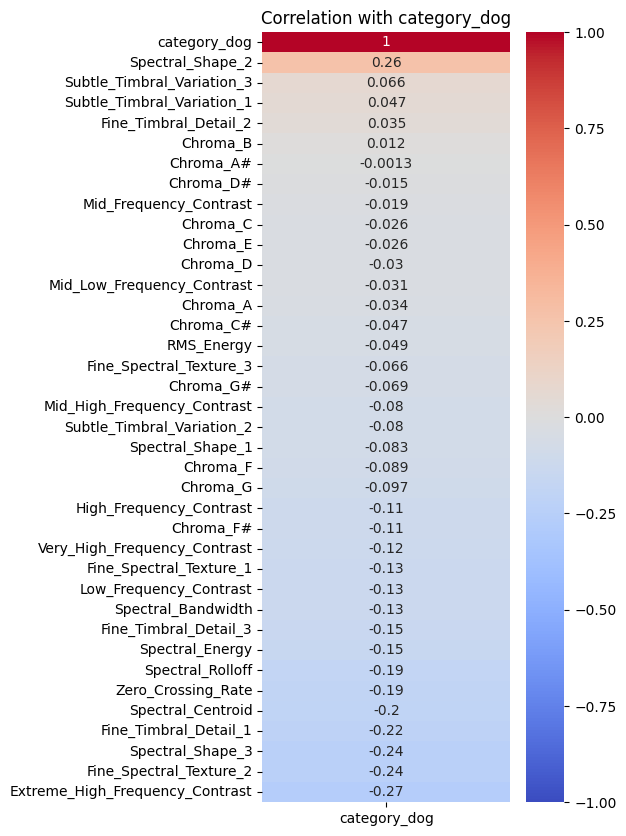

In [76]:
#Correlation for dog
corr_matrix_dog = animal_dataframes['dog'].corr()

# Focus on the 'is_dog' correlations
corr_with_is_dog = corr_matrix_dog[['category_dog']]

# Create a heatmap
plt.figure(figsize=(4, 10))  # Adjust the figure size as needed
sb.heatmap(corr_with_is_dog.sort_values(by='category_dog', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with category_dog')

# Show the plot
plt.show()

## Correlation between audio features and chirping birds

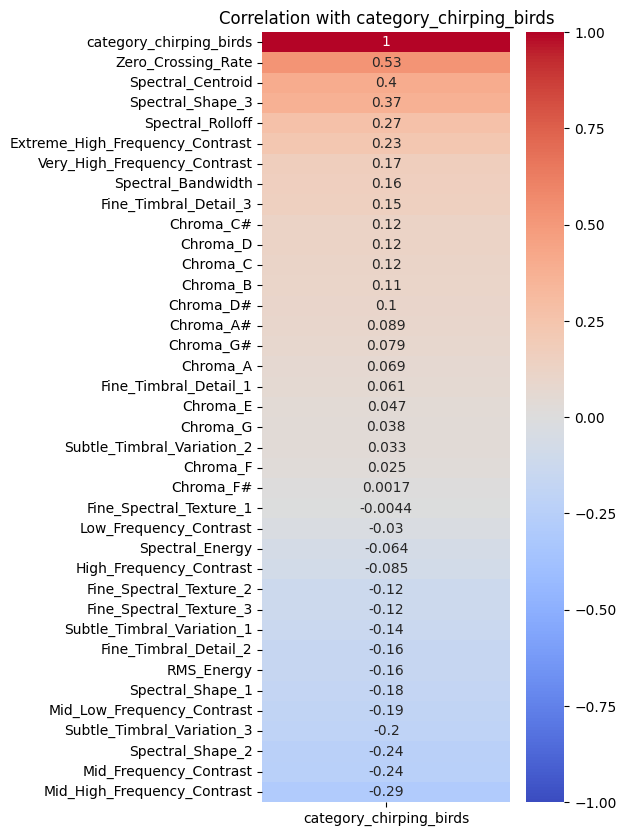

In [77]:
#Correlation for chirping birds
corr_matrix_chirping_birds = animal_dataframes['chirping_birds'].corr()

# Focus on the 'is_chirping_birds' correlations
corr_with_is_chirping_birds = corr_matrix_chirping_birds[['category_chirping_birds']]

# Create a heatmap
plt.figure(figsize=(4, 10))  # Adjust the figure size as needed
sb.heatmap(corr_with_is_chirping_birds.sort_values(by='category_chirping_birds', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with category_chirping_birds')

# Show the plot
plt.show()

## Correlation between audio features and crows

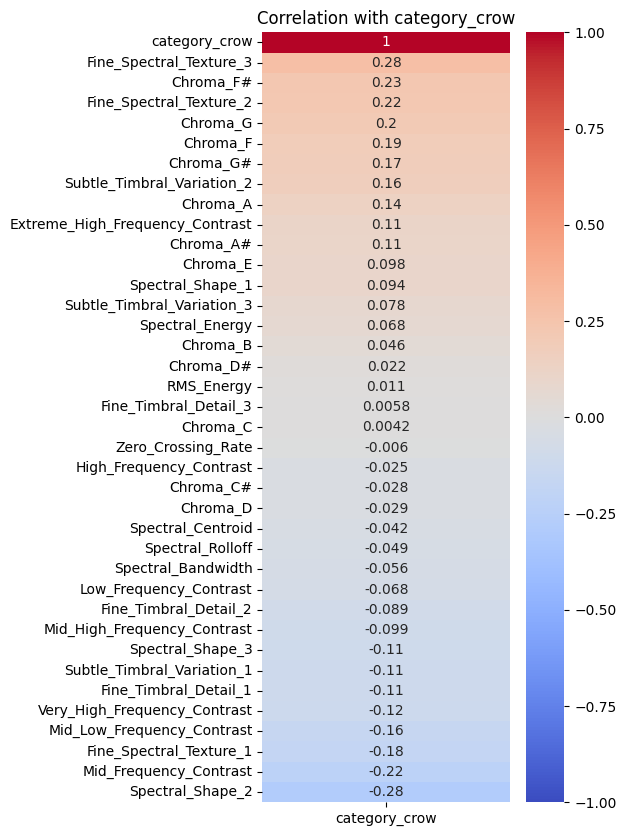

In [78]:
#Correlation for crow
corr_matrix_crow = animal_dataframes['crow'].corr()

# Focus on the 'is_crow' correlations
corr_with_is_crow = corr_matrix_crow[['category_crow']]

# Create a heatmap
plt.figure(figsize=(4, 10))  # Adjust the figure size as needed
sb.heatmap(corr_with_is_crow.sort_values(by='category_crow', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with category_crow')

# Show the plot
plt.show()

## Correlation between audio features and sheeps

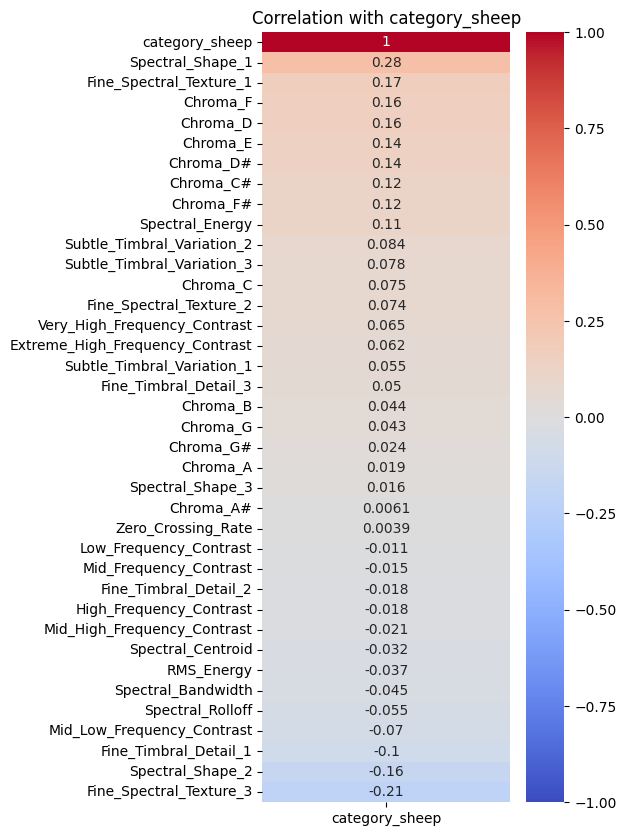

In [79]:
#Correlation for sheep
corr_matrix_sheep = animal_dataframes['sheep'].corr()

# Focus on the 'is_sheep' correlations
corr_with_is_sheep = corr_matrix_sheep[['category_sheep']]

# Create a heatmap
plt.figure(figsize=(4, 10))  # Adjust the figure size as needed
sb.heatmap(corr_with_is_sheep.sort_values(by='category_sheep', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with category_sheep')

# Show the plot
plt.show()

## Correlation between audio features and frogs

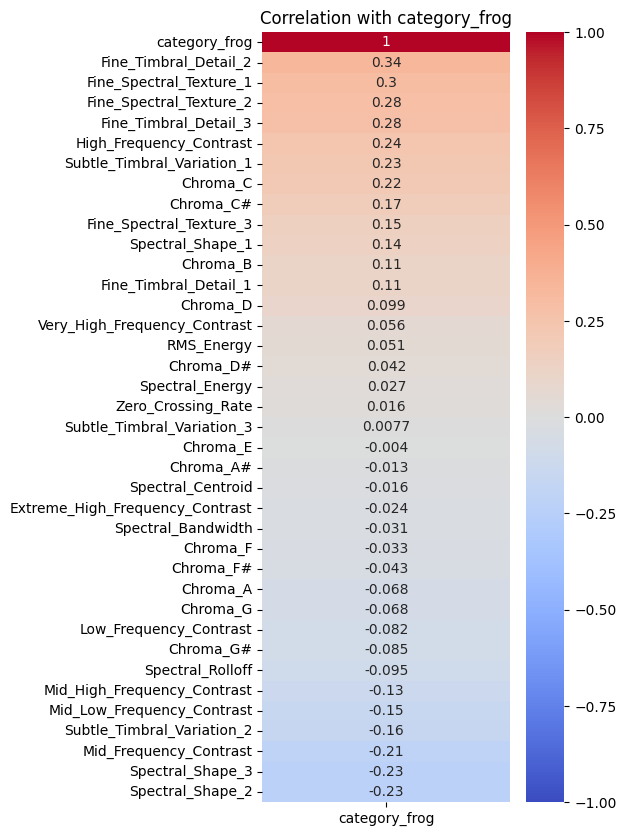

In [80]:
#Correlation for frog
corr_matrix_frog = animal_dataframes['frog'].corr()

# Focus on the 'is_frog' correlations
corr_with_is_frog = corr_matrix_frog[['category_frog']]

# Create a heatmap
plt.figure(figsize=(4, 10))  # Adjust the figure size as needed
sb.heatmap(corr_with_is_frog.sort_values(by='category_frog', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with category_frog')

# Show the plot
plt.show()

## Correlation between audio features and cows

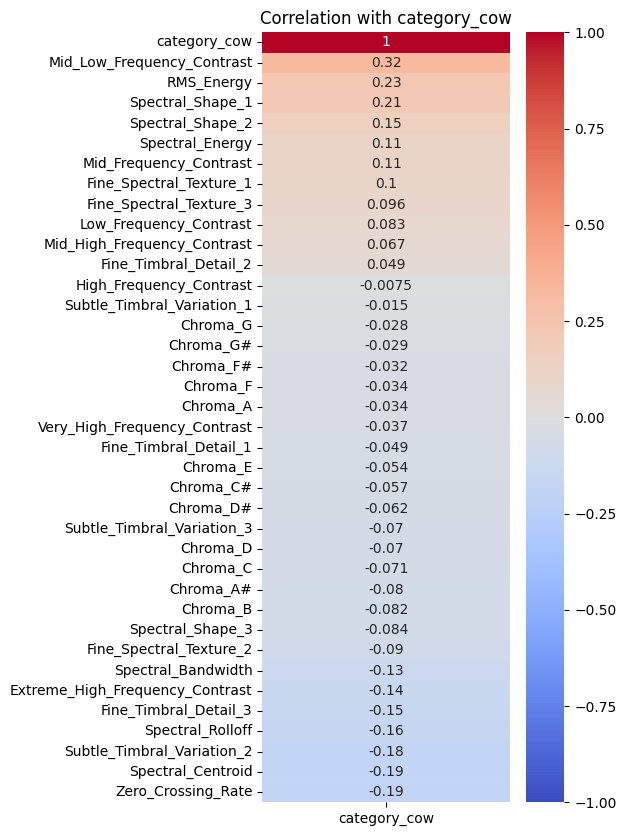

In [81]:
#Correlation for cow
corr_matrix_cow = animal_dataframes['cow'].corr()

# Focus on the 'is_crow' correlations
corr_with_is_cow = corr_matrix_cow[['category_cow']]

# Create a heatmap
plt.figure(figsize=(4, 10))  # Adjust the figure size as needed
sb.heatmap(corr_with_is_cow.sort_values(by='category_cow', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with category_cow')

# Show the plot
plt.show()

## Correlation between audio features and insects

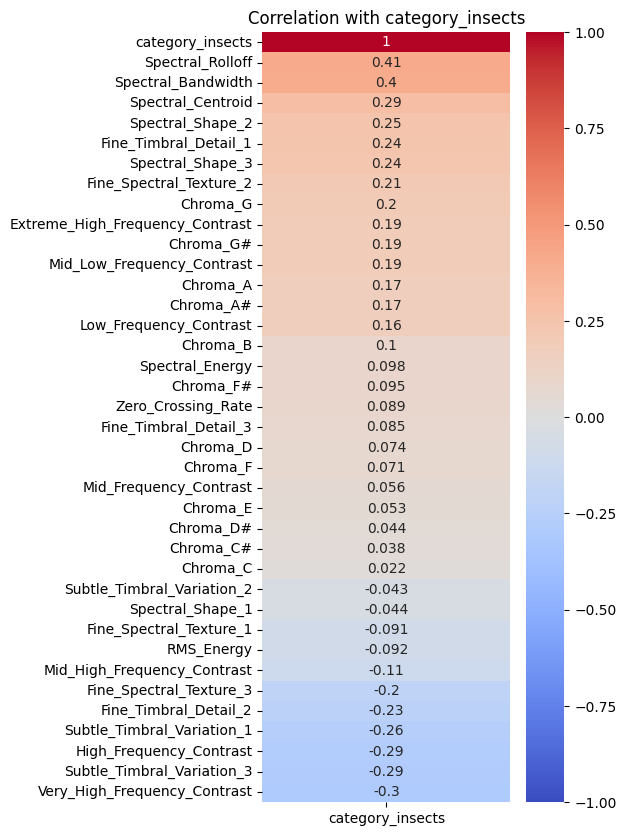

In [82]:
#Correlation for insect
corr_matrix_insects = animal_dataframes['insects'].corr()

# Focus on the 'is_insects' correlations
corr_with_is_insect = corr_matrix_insects[['category_insects']]

# Create a heatmap
plt.figure(figsize=(4, 10))  # Adjust the figure size as needed
sb.heatmap(corr_with_is_insect.sort_values(by='category_insects', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with category_insects')

# Show the plot
plt.show()

## Correlation between audio features and hens

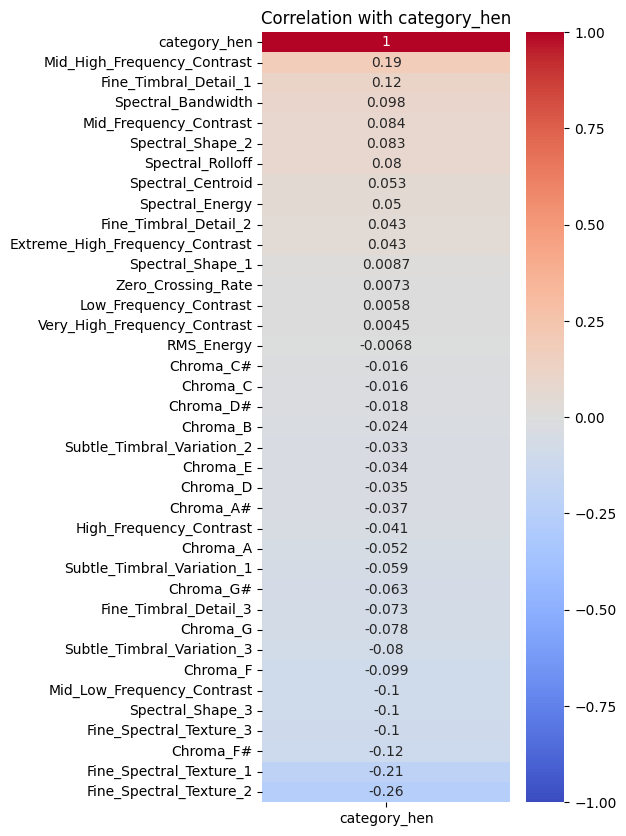

In [83]:
#Correlation for hen
corr_matrix_hen = animal_dataframes['hen'].corr()

# Focus on the 'is_hen' correlations
corr_with_is_hen = corr_matrix_hen[['category_hen']]

# Create a heatmap
plt.figure(figsize=(4, 10))  # Adjust the figure size as needed
sb.heatmap(corr_with_is_hen.sort_values(by='category_hen', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with category_hen')

# Show the plot
plt.show()

## Correlation between audio features and pigs

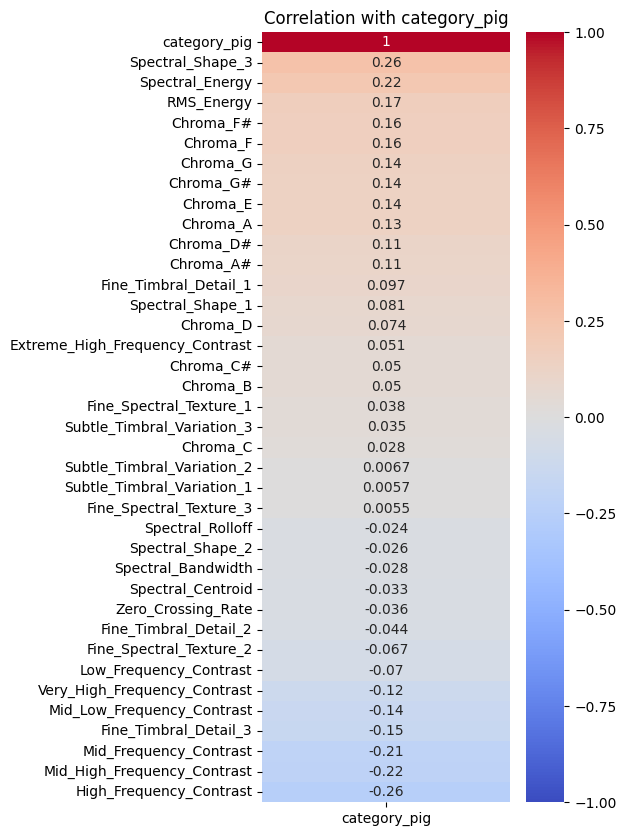

In [84]:
#Correlation for pig
corr_matrix_pig = animal_dataframes['pig'].corr()

# Focus on the 'is_pig' correlations
corr_with_is_pig = corr_matrix_pig[['category_pig']]

# Create a heatmap
plt.figure(figsize=(4, 10))  # Adjust the figure size as needed
sb.heatmap(corr_with_is_pig.sort_values(by='category_pig', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with category_pig')

# Show the plot
plt.show()

## Correlation between audio features and roosters

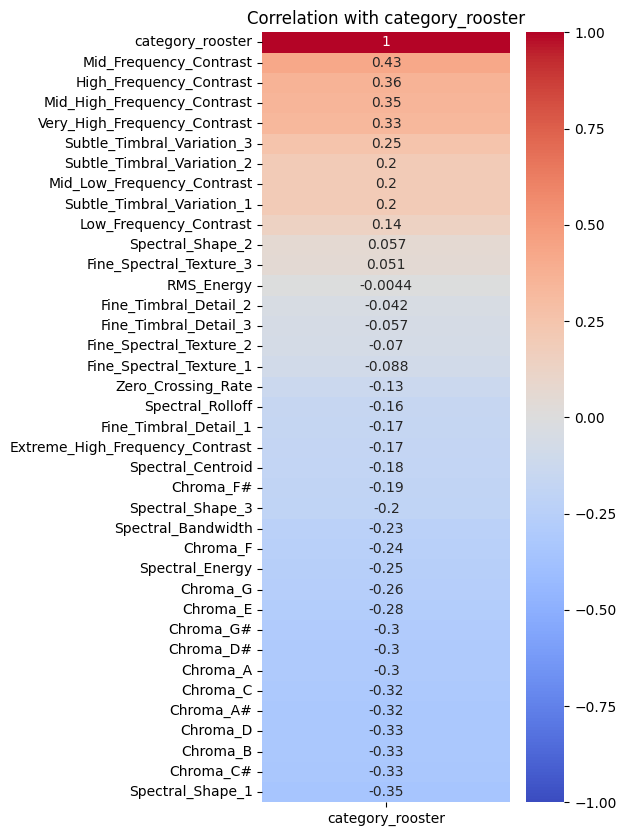

In [85]:
#Correlation for rooster
corr_matrix_rooster = animal_dataframes['rooster'].corr()

# Focus on the 'is_rooster' correlations
corr_with_is_rooster = corr_matrix_rooster[['category_rooster']]

# Create a heatmap
plt.figure(figsize=(4, 10))  # Adjust the figure size as needed
sb.heatmap(corr_with_is_rooster.sort_values(by='category_rooster', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with category_rooster')

# Show the plot
plt.show()

## Correlation between audio features and cats

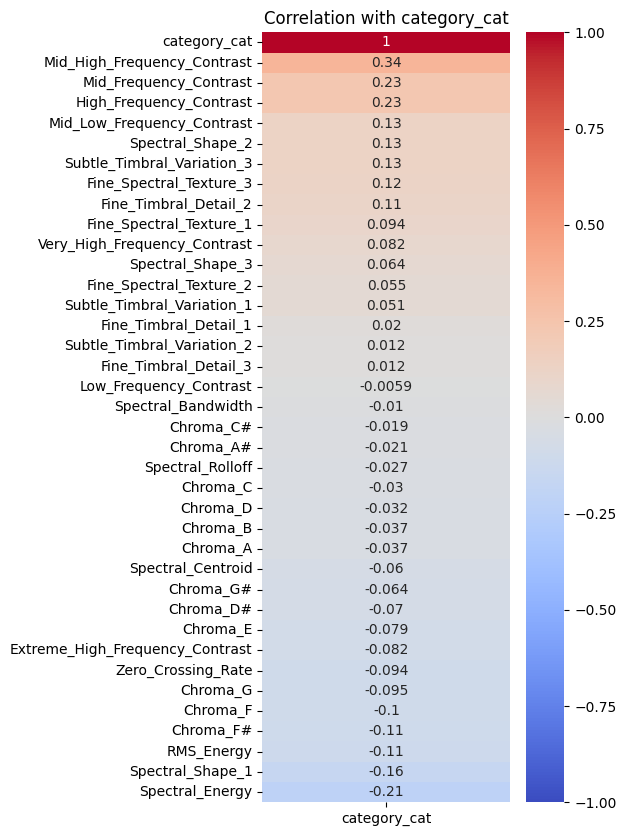

In [86]:
#Correlation for cats
corr_matrix_cat = animal_dataframes['cat'].corr()

# Focus on the 'is_cat' correlations
corr_with_is_cat = corr_matrix_cat[['category_cat']]

# Create a heatmap
plt.figure(figsize=(4, 10))  # Adjust the figure size as needed
sb.heatmap(corr_with_is_cat.sort_values(by='category_cat', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with category_cat')

# Show the plot
plt.show()

category_cat: Mid_High_Frequency_Contrast, Mid_Frequency_Contrast, High_Frequency_Contrast, Spectral_Energy, Spectral_Shape_1

category_rooster: Mid_Frequency_Contrast, High_Frequency_Contrast, Mid_High_Frequency_Contrast, Very_High_Frequency_Contrast, Spectral_Shape_1,     Chroma_C#, Chroma_B, Chroma_D, Chroma_A#, Chroma_C - JUSTIFY NOT INCLUDING SO MANY FEATURES

category_pig: Spectral_Shape_3, Specral_Energy, High_Frequency_Contrast, Mid_High_Frequency_Contrast, Mid_Frequency_Contrast

category_hen: Mid_High_Frequency_Contrast, Fine_Timbral_Detail_1, Fine_Spectral_Texture_2, Fine_Spectral_Texture_1

category_insects: Spectral_Rolloff, Spectral_Bandwidth, High_Frequency_Contrast, Subtle_Timbral_Vibration_3, High_Frequency_Contrast, Subtle_Timbral_Variation_1

category_cow: Mid_Low_Frequency_Contrast, RMS_Energy, Spectral_Shape_1

category_frog: Fine_Timbral_Detail_2, Fine_Spectral_Texture_1, Fine_Spectral_Texture_2, Fine_Timbral_Detail_3, Spectral_Shape_2, Specral_Shape_3, Mid_Frequency_Contrast

category_sheep: Spectral_Shape_1, Spectral_Texture_3

category_crow: Fine_Spectral_Texture_3, Chroma_F#, Fine_Spectral_Texture_2, Spectral_Shape_2

category_chirping_birds: Zero_Crossing_Rate, Spectral_Centroid, Spectral_Shape_3, Mid_High_Frequency_Contrast

category_dog: Spectral_Shape_2, Extreme_High_Frequency_Contrast

Mid_High_Frequency_Contrast: It has a strong correlation with 6 animals
Spectral_Shape_3: Although it only has a strong correlation with 2 animals, its correlation with chirping birds is very high (0.37) and it is the audio feature with the strongest correlation to pig (0.26)
Mid_Frequency_Contrast: It has a strong correlation with 4 animals and high correlation with rooster (0.43)
High_Frequency_Contrast: It has a strong correlation with 5 animals and high correlation with rooster (0.36)
Mid_Low_Frequency_Contrast: Although the only animal it is strongly correlated to is cows, it has the strongest correlation with cows as compared to other audio features for cow and the correlation between other audio features and cow are relatively low
Spectral_Shape_1: It has a strong correlation with 4 animals and the audio feature that has the strongest correlation with sheep is 'Spectral_Shape_1'
- Fine_Spectral_Texture_2: Although it only has a strong correlation with 3 animals, it is the audio feature that has the strongest correlation with hens
Spectral_Rolloff: Although the only animal it is strongly correlated to with is insects, it is the audio feature that has the strongest correlation with insects and the correlation coefficient is very high it is 0.41
Spectral_Bandwidth: Although the only animal it is strongly correlated to with is insects, it has a very strong correlation with insects, 0.4
Fine_Timbral_Detail_2: Although the only animal it is strongly correlared to is frogs, it is the audio feature that has the strongest correlation with frogs, 0.34
- Spectral_Shape_2: Although it is only strongly correlated to 3 animals (frog, crow and dog), it is the the audio feature with the strongest/2nd strongest correlation with crow and dog
Fine_Spectral_Texture_3: Although it is only strongly correlated to 1 animal which is crow, it is the audio feature with the strongest correlation to crow, together with 'Spectral_Shape_2'
Zero_Crossing_Rate: Although it is only strong correlated to 1 animal which is chirping_birds, it is the audio feature with the strongest correlation to chirping_birds and its correlation with chirping_birds is also extremely high,0.53
Spectral_Centroid: Although it is only strong correlated to 1 animal which is chirping_birds, it is the audio feature with the strongest correlation to chirping_birds and its correlation with chirping_birds is also extremely high,0.4
- Extreme_High_Frequency_Contrast: Although it is only strongly correlated to 1 animal which is dog, it is the audio feature with the strongest correlation to dogs, -0.27



In [87]:
important_features_final = ['Mid_High_Frequency_Contrast','Spectral_Shape_3','Mid_Frequency_Contrast','High_Frequency_Contrast','Mid_Low_Frequency_Contrast', 'Spectral_Shape_1', 'Fine_Spectral_Texture_2', 'Spectral_Rolloff', 'Spectral_Bandwidth', 'Fine_Timbral_Detail_2', 'Spectral_Shape_2', 'Fine_Spectral_Texture_3', 'Zero_Crossing_Rate' 'Spectral_Centroid', 'Extreme_High_Frequency_Contrast']

In [88]:
# #Comparing important audio feature to different types of animals
# animal_metadata_important = animal_metadata.filter(important_features_1+['category'])

# animal_metadata_important_encoded = pd.get_dummies(animal_metadata_important, columns=['category'])
# correlations_important= animal_metadata_important_encoded.corr()

# # Plotting a heatmap
# plt.figure(figsize=(12, 10))
# sb.heatmap(correlations_important, 
#             cmap='coolwarm', 
#             center=0, 
#             annot=False,  # You can set this to True if you want to see the correlation values
#             fmt=".2f",    # Formatting the annotation if annot=True
#             linewidths=.5,
#             cbar_kws={'shrink': .5, 'label': 'Correlation coefficient'})
# plt.title('Correlation Heatmap between important Audio Features and Animal Categories')
# plt.xticks(rotation=45, ha="right")
# plt.yticks(rotation=0)
# plt.tight_layout()
# plt.show()

In [89]:
# # Identifying important features to find out which animal made that sound
# feature_important_columns = [col for col in animal_metadata_important_encoded.columns if not col.startswith('category_')]
# category_important_columns = [col for col in animal_metadata_important_encoded.columns if col.startswith('category_')]

# feature_to_category_corr = correlations_important.loc[feature_important_columns, category_important_columns]

# mean_abs_corr_per_feature = feature_to_category_corr.abs().mean(axis=1)

# # Plotting a bar plot for the mean absolute correlation of each feature with categories
# plt.figure(figsize=(12, 6))
# mean_abs_corr_per_feature.sort_values(ascending=False).plot(kind='bar')
# plt.title('Mean Absolute Correlation of Each Feature with Categories')
# plt.ylabel('Mean Absolute Correlation with Categories')
# plt.xlabel('Features')
# plt.xticks(rotation=45, ha="right")  # Rotate feature names for better readability
# plt.tight_layout()
# plt.show()

# important_features_2 = ['Mid_High_Frequency_Contrast','Spectral_Shape_3','Mid_Frequency_Contrast','High_Frequency_Contrast','Mid_Low_Frequency_Contrast']

In [90]:
correlations = animal_metadata_encoded.corr()

# # Plotting a heatmap
# plt.figure(figsize=(12, 10))
# sb.heatmap(correlations, 
#             cmap='coolwarm', 
#             center=0, 
#             annot=False,  # You can set this to True if you want to see the correlation values
#             fmt=".2f",    # Formatting the annotation if annot=True
#             linewidths=.5,
#             cbar_kws={'shrink': .5, 'label': 'Correlation coefficient'})
# plt.title('Correlation Heatmap between Audio Features and Animal Categories')
# plt.xticks(rotation=45, ha="right")
# plt.yticks(rotation=0)
# plt.tight_layout()
# plt.show()

# Max Absolute Correlation of Each Feature with Categories

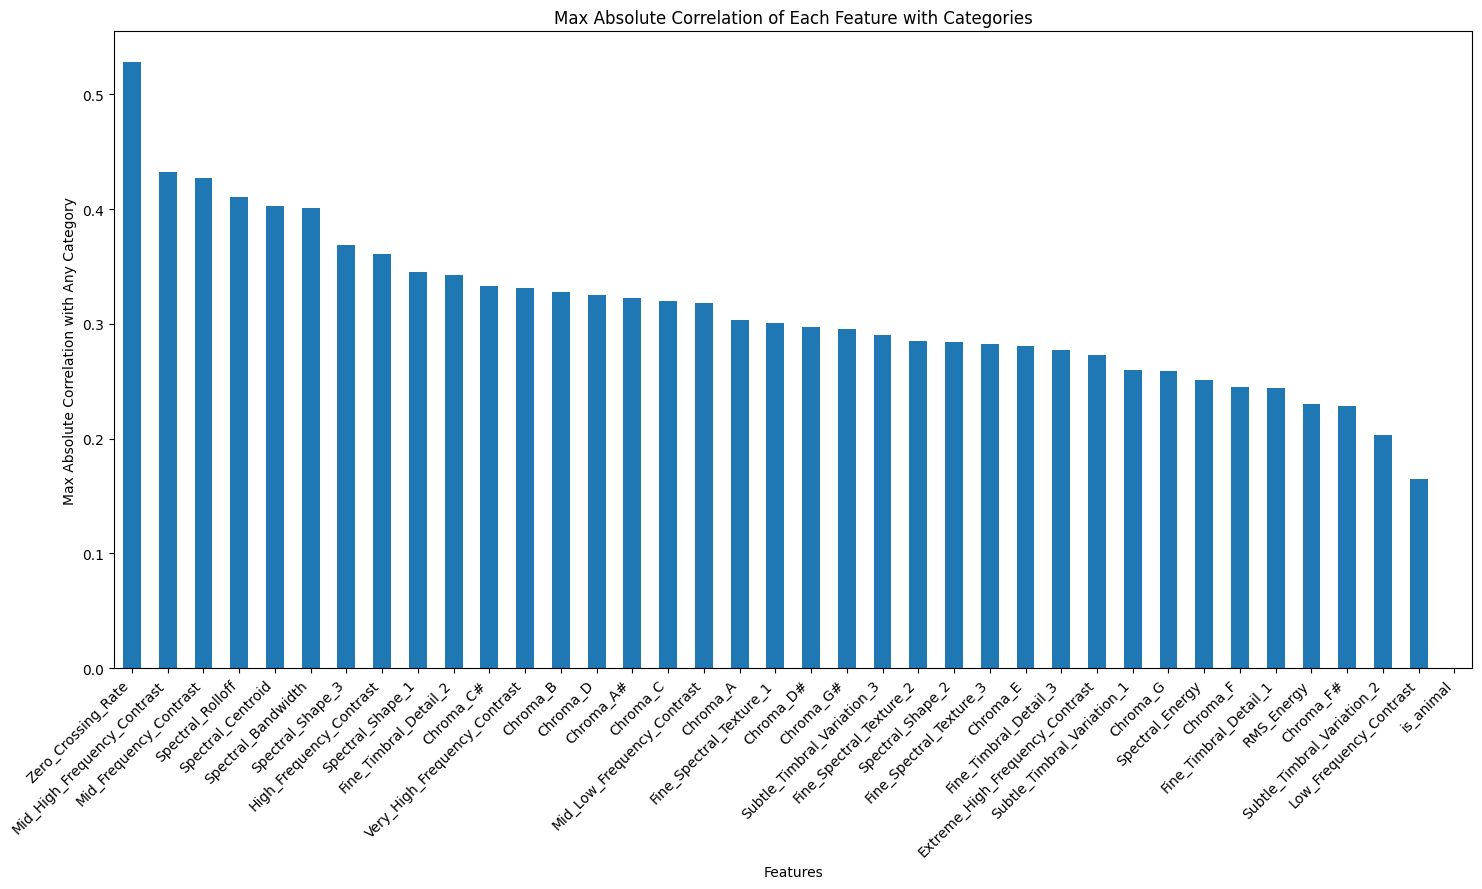

In [91]:

feature_columns = [col for col in animal_metadata_encoded.columns if not col.startswith('category_')]
category_columns = [col for col in animal_metadata_encoded.columns if col.startswith('category_')]

# Now, extract the correlations between features and categories directly
feature_to_category_corr = correlations.loc[feature_columns, category_columns]

# Calculate the maximum absolute correlation for each feature
max_abs_corr_per_feature = feature_to_category_corr.abs().max(axis=1)

# Plotting a bar plot for the summary statistic of each feature
plt.figure(figsize=(15, 9))
max_abs_corr_per_feature.sort_values(ascending=False).plot(kind='bar')
plt.title('Max Absolute Correlation of Each Feature with Categories')
plt.ylabel('Max Absolute Correlation with Any Category')
plt.xlabel('Features')
plt.xticks(rotation=45, ha="right")  # Rotate feature names for better readability
plt.tight_layout()
plt.show()


# Mean Absoulte Correlation Per Feature

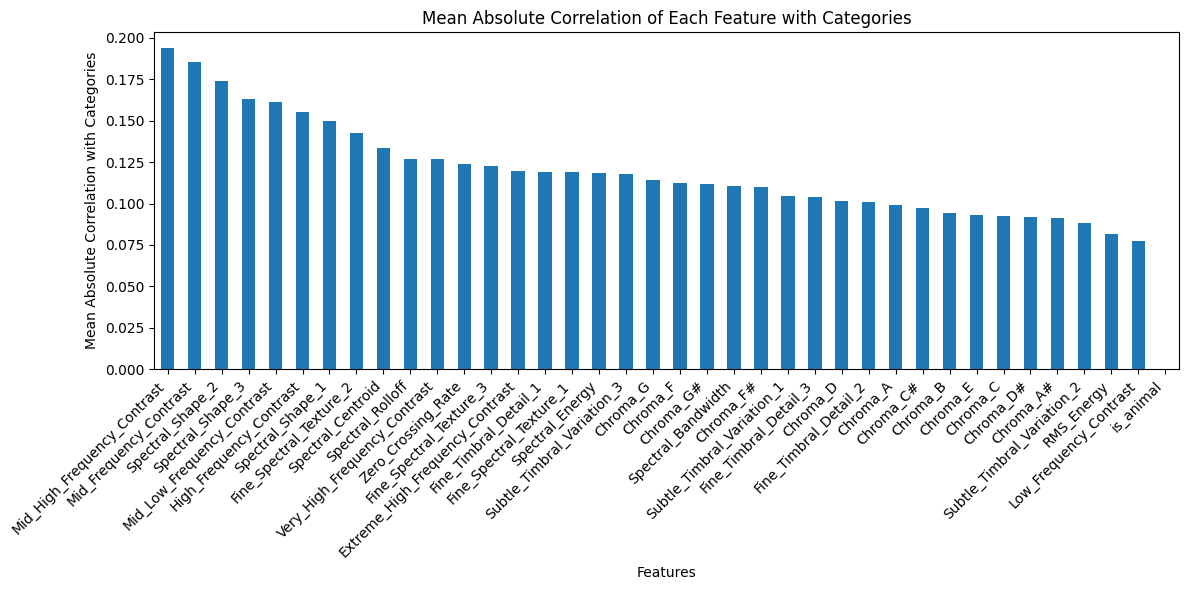

In [92]:
mean_abs_corr_per_feature = feature_to_category_corr.abs().mean(axis=1)

# Plotting a bar plot for the mean absolute correlation of each feature with categories
plt.figure(figsize=(12, 6))
mean_abs_corr_per_feature.sort_values(ascending=False).plot(kind='bar')
plt.title('Mean Absolute Correlation of Each Feature with Categories')
plt.ylabel('Mean Absolute Correlation with Categories')
plt.xlabel('Features')
plt.xticks(rotation=45, ha="right")  # Rotate feature names for better readability
plt.tight_layout()
plt.show()

# Boxplot analysis of Mid_High_Frequency_Contrast
This feature quantifies how much energy is present in the mid-frequency range compared to the high-frequency range. It's useful for detecting sounds with sharp transitions or edges in these frequency ranges. For example, it might help in identifying the chirping of birds.


### Retaining Outliers
There is a large amount of outliers which indicated significant variations in the data. This could be due to environmental sounds having different frequency profiles compared to animal vocalizations, resulting in the many outliers. However, it may also be true that the many outliers could be due to different species producing a wide range of sound patterns. 

Although it is true that retaining the outliers may affect the accuracy of our model, we have decided to retain the outliers as we believe they are largely due to the frequency differences between environmental sounds and animal vocalizations and are crucial in helping us determine if a sound is an animal sound. Additionally, since majority of the dataset lies outside the standard deviation, removing the outliers would drastically reduce the amount of available data, leaving very little data for analysis which may lead to a biased or incomplete understanding of sound patterns. Training models on such a restricted dataset could result in even greater inaccuracies and reduced model performance|. 

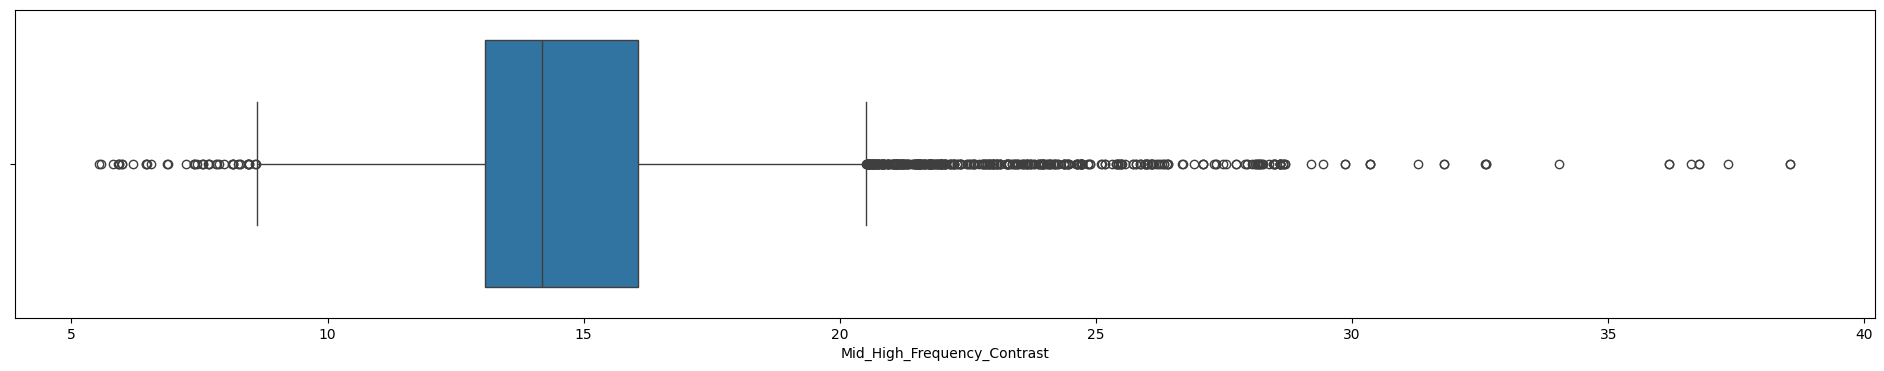

In [93]:
# Assuming 'metadata' is your DataFrame and it contains a 'Mid_High_Frequency_Contrast' column
f = plt.figure(figsize=(24, 4))
sb.boxplot(data=metadata['Mid_High_Frequency_Contrast'], orient="h")
plt.show()


# Boxplot analysis of Spectral_Shape_3
This feature provides insights into the overall shape of the frequency spectrum of the audio signal. While there may be various ways to calculate spectral shape features, Spectral_Shape_3 likely focuses on a specific parameterization or calculation method. It could reveal patterns in the distribution of frequencies, which might help differentiate between different types of animal calls or environmental sounds.

For example, if animal has strong correlation with Spectral_Shape_3, that animal produces sounds with distinct spectral shapes that differ from other animals or background noise present in the audio recordings. 

For example, dogs may have specific patterns in their barking or howling that manifest as unique shapes in the frequency spectrum, which can be captured by the feature "Spectral_Shape_3"

### Retaining Outliers

There is a moderate amount of outliers which could be due to the fact thart animal vocalizations exhibit diverse spectral characteristics due to difference in species. Animal vocalizations can be complex, containing multiple frequency components and intricate spectral patterns. Variations in vocalization types such as calls and cries may lead to outliers in spectral_shape_3. Factors like recording equipment, environmental conditions and background noise levels can also influence the spectral characteristics of recorded sounds.

Although it is true that outliers may affect the performance of our detection algorithm, we believe that the outliers represent genuine variations in animal vocalizations and they are relevant for detecting specific animal species as different specifies have unique spectral_patterns. Therefore, we have decided to retain the outliers.



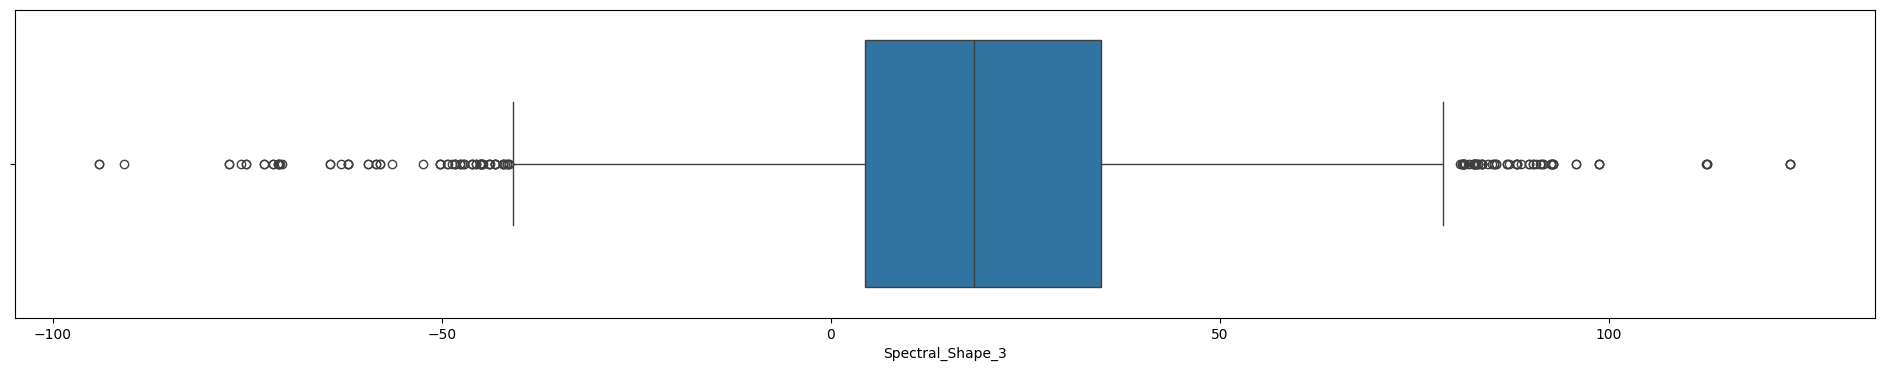

In [94]:
# Assuming 'metadata' is your DataFrame and it contains a 'Spectral_Shape_3' column
f = plt.figure(figsize=(24, 4))
sb.boxplot(data=metadata['Spectral_Shape_3'], orient="h")
plt.show()

# Boxplot analysis of Mid_Frequency_Contrast

Similar to Mid_High_Frequency_Contrast, but specifically targeting the mid-frequency range. This feature helps in understanding how energy is distributed within this particular frequency band, which could be crucial for discerning sounds that are dominant in mid-frequency content, such as certain animal vocalizations or machinery noises.

### Retaining Outliers
The outliers represent the diverse range of sounds. Both animal and environmental sounds exhibit diverse spectral characteristics due to species differences, leading to variations in mid-frequency contrast values. 

Since majority of the dataset lies outside the standard deviation, removing the outliers would result in only a small amount of data left which can result in an overly-biased model that does not factor in the diverse range of sounds. Although it is true that the outliers will affect the model accuracy, we believe that removing the outliers would further affect the accuracy and have hence decided to retain the outliers. 

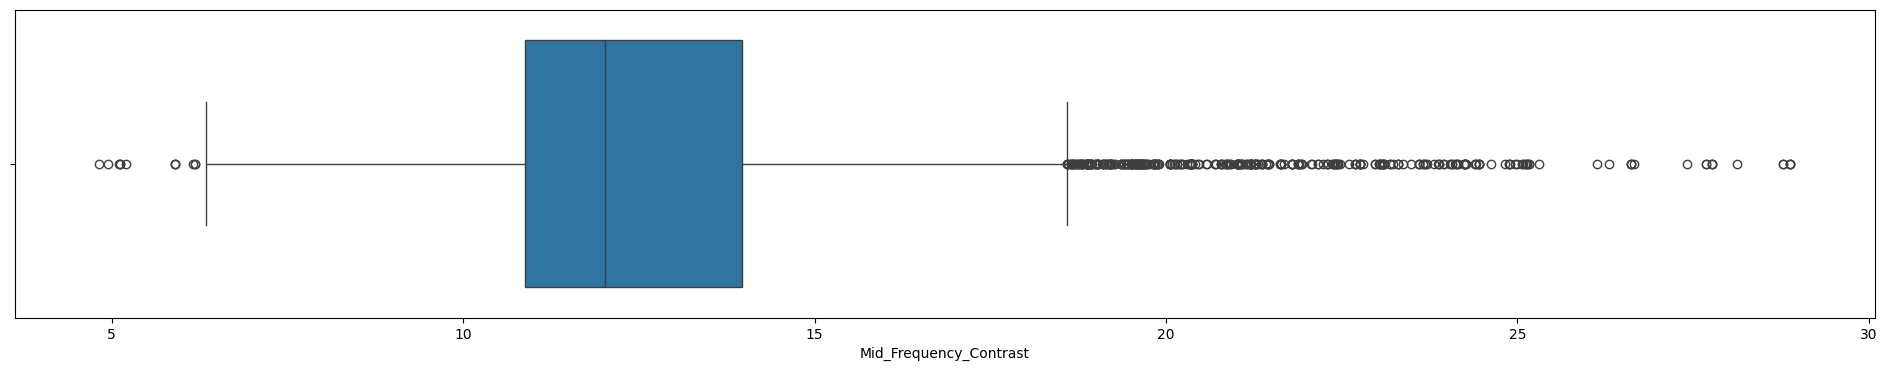

In [95]:
# Assuming 'metadata' is your DataFrame and it contains a 'Mid_Frequency_Contrast' column
f = plt.figure(figsize=(24, 4))
sb.boxplot(data=metadata['Mid_Frequency_Contrast'], orient="h")
plt.show()

# Boxplot analysis of High_Frequency_Contrast

This feature measures the difference in energy between high frequencies in the audio signal. It's particularly valuable for detecting high-pitched sounds or sharp transients, which might be indicative of certain animal calls, such as bird songs or insect sounds.

### Retaining Outliers
The presence of the many outliers could stem from animal vocalizations and certain evnrionmental sounds exhibiting distint spectral characteristics including pronounced contrasts in high-frquency energy. Additionally, majority of the data lies outside the standard deviation and removing the outliers would result in a biased model.

We have hence decided to retain the outliers. Retaining outliers ensures that the dataset encompasses a wide range of sound characteristics that may be crucial for identifying specific animal specifies. For example. frogs are known for their distinct vocalizations which often include high-frequency components. These vocalizations typically consists of series of croaks or chirps with variations in pitch and intensity. Retaining outliers for this feature would capture the unique spectral patterns in frog vocalizations.

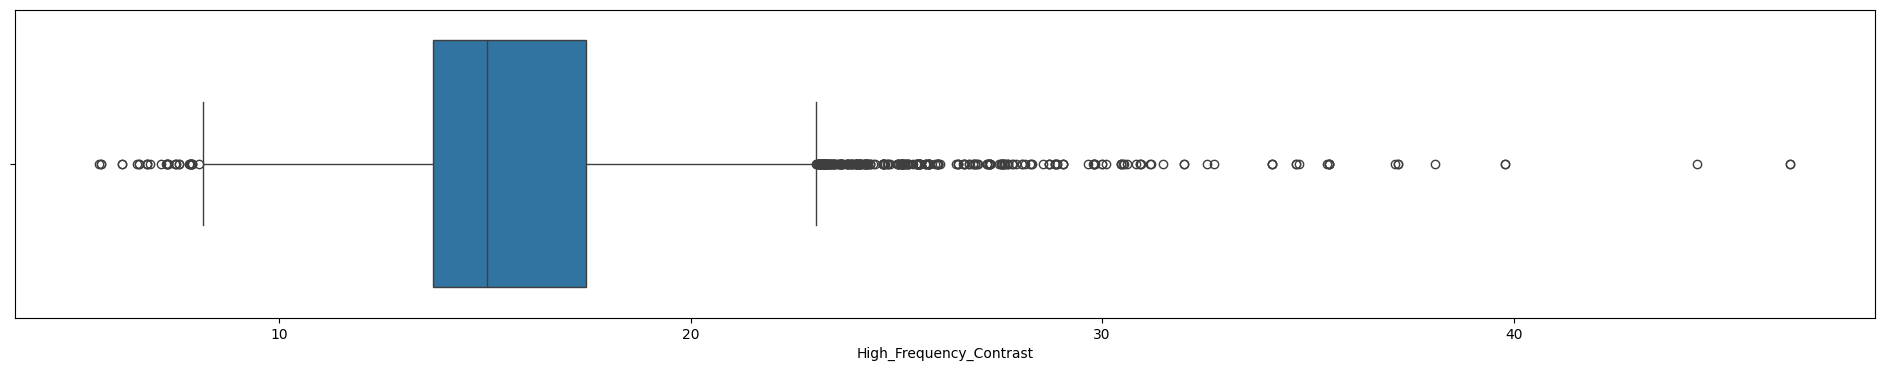

In [96]:
# Assuming 'metadata' is your DataFrame and it contains a 'High_Frequency_Contrast' column
f = plt.figure(figsize=(24, 4))
sb.boxplot(data=metadata['High_Frequency_Contrast'], orient="h")
plt.show()

# Boxplot analysis of Mid_Low_Frequency_Contrast

Similar to Mid_High_Frequency_Contrast, but focusing on the mid-low frequency range. This feature helps in analyzing the energy distribution within this frequency band, which could be relevant for identifying sounds like distant animal growls or low-frequency environmental noises.

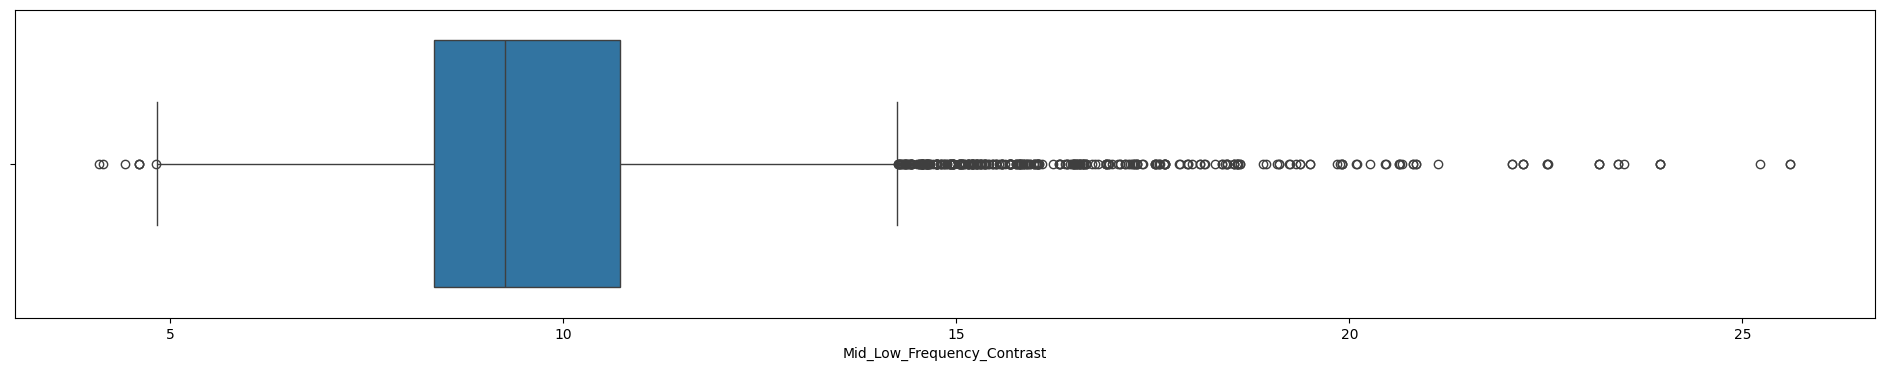

In [97]:
# Assuming 'metadata' is your DataFrame and it contains a 'Mid_Low_Frequency_Contrast' column
f = plt.figure(figsize=(24, 4))
sb.boxplot(data=metadata['Mid_Low_Frequency_Contrast'], orient="h")
plt.show()

# Boxplot analysis of Spectral_Shape_1

Another descriptor of the spectral shape, likely employing a different approach than Spectral_Shape_3. This feature might capture different aspects of the frequency spectrum's shape, providing complementary information for sound analysis and classification.

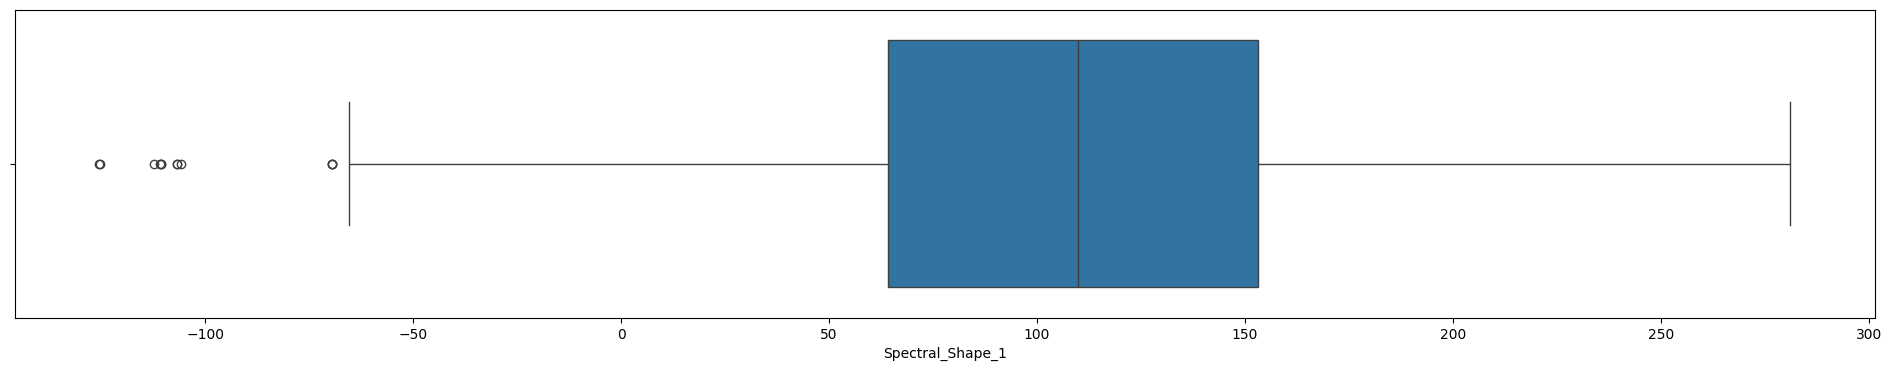

In [98]:
# Assuming 'metadata' is your DataFrame and it contains a 'Spectral_Shape_1' column
f = plt.figure(figsize=(24, 4))
sb.boxplot(data=metadata['Spectral_Shape_1'], orient="h")
plt.show()

# Boxplot analysis of Spectral_Rolloff

Spectral rolloff represents the frequency below which a certain percentage of the total spectral energy lies, indicating the distribution of energy in the frequency spectrum. A high correlation with spectral rolloff suggests that the phenomenon under study exhibits spectral characteristics aligned with the concentration of energy at certain frequencies, as represented by the spectral rolloff value.

For instance, if "is_birdsong" has a high correlation with spectral rolloff, it suggests that bird songs tend to exhibit distinct spectral characteristics where a significant portion of the energy is concentrated at lower frequencies.

A high spectral rolloff value suggests that most of the spectral energy is concentrated at lower frequencies, while a low value indicates that energy extends to higher frequencies. In audio signals, high-frequency components often contribute to the perceived brightness or treble of the sound.

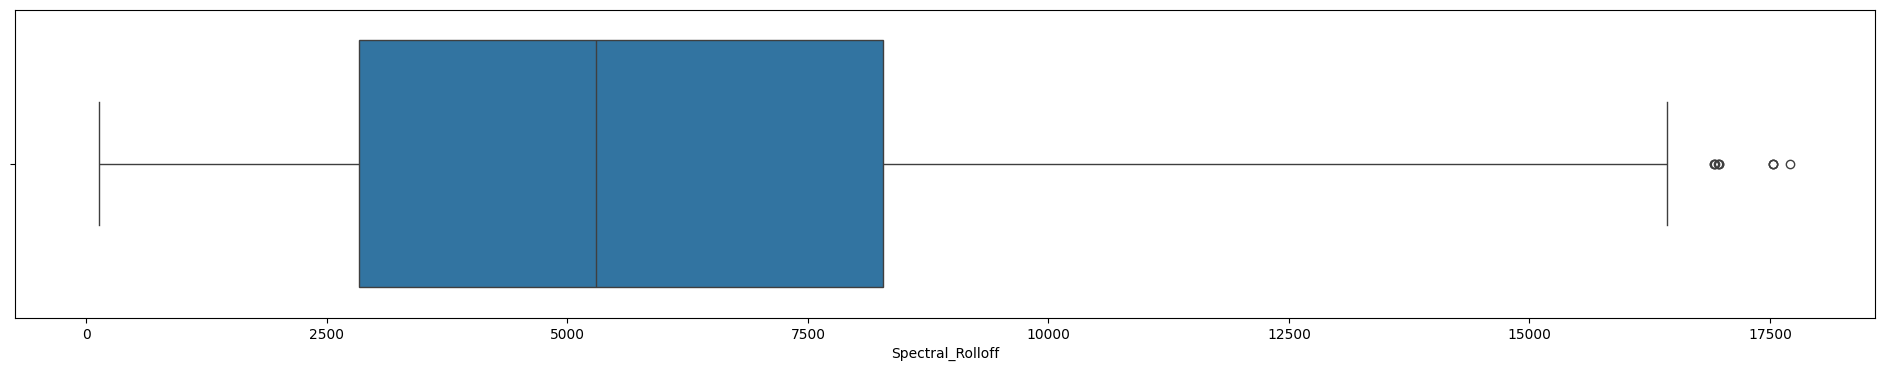

In [99]:
# Assuming 'metadata' is your DataFrame and it contains a 'Spectral_Rolloff' column
f = plt.figure(figsize=(24, 4))
sb.boxplot(data=metadata['Spectral_Rolloff'], orient="h")
plt.show()

# Boxplot analysis of Spectral_Bandwidth

This feature measures the width of the frequency range that contains a certain percentage of the total spectral energy. It reveals how spread out the energy is across frequencies, which is useful for distinguishing between sounds with different spectral distributions. For instance, it might help differentiate between narrowband sounds like whistles and broadband sounds like animal vocalizations.

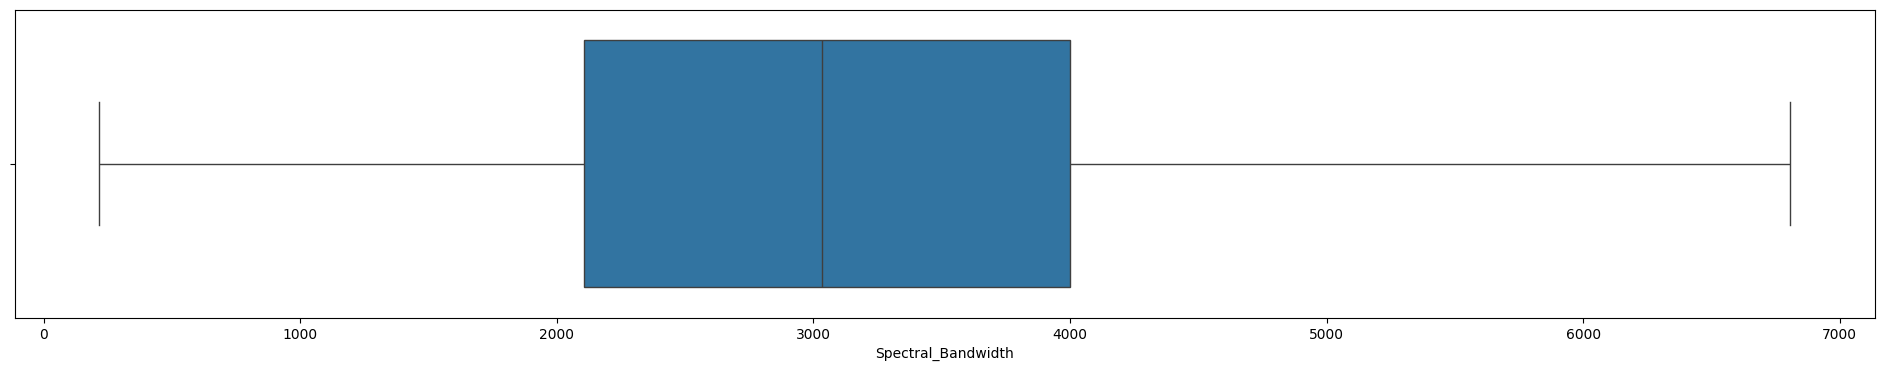

In [100]:
# Assuming 'metadata' is your DataFrame and it contains a 'Spectral_Bandwidth' column
f = plt.figure(figsize=(24, 4))
sb.boxplot(data=metadata['Spectral_Bandwidth'], orient="h")
plt.show()

# Boxplot analysis of Fine_Timbral_Detail_2

This feature captures subtle variations or nuances in the timbre of the sound. It likely focuses on detailed features related to texture or tonal quality, which can be crucial for discriminating between similar sounds or detecting variations within the same sound category, such as different bird species or individual animal calls.

In essence, a high correlation with Fine_Timbral_Detail_2 indicates that the phenomenon being studied exhibits timbral characteristics that are well-captured by the nuanced features encapsulated in Fine_Timbral_Detail_2. This information can be valuable for tasks such as sound classification, where distinguishing between different sound sources or categories relies heavily on their unique timbral qualities.


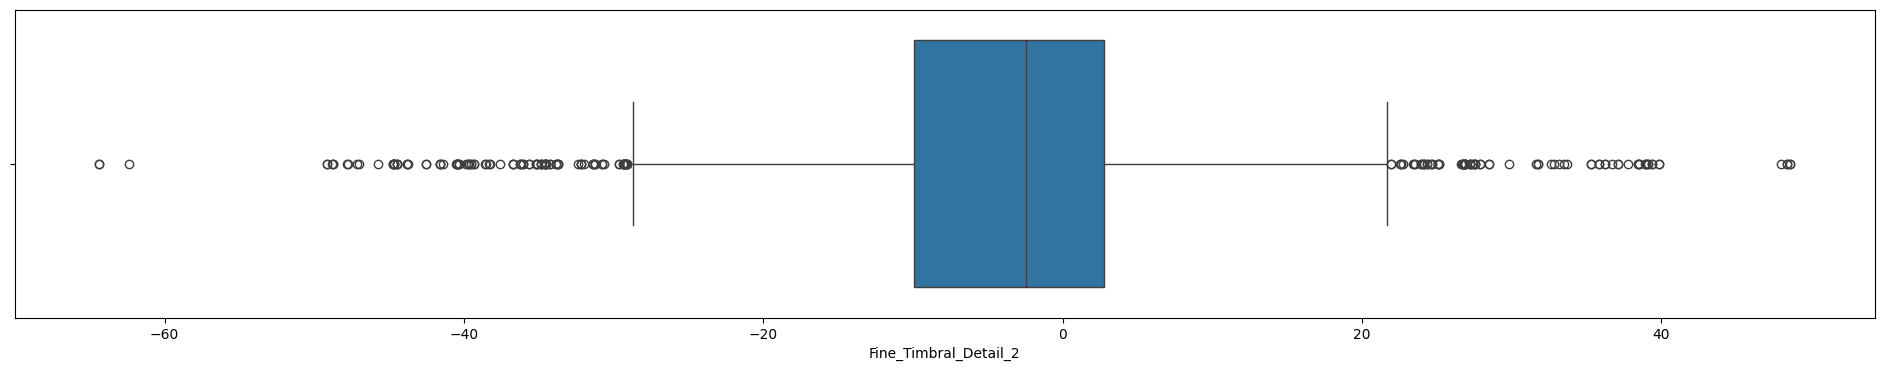

In [101]:
# Assuming 'metadata' is your DataFrame and it contains a 'Fine_Timbral_Detail_2' column
f = plt.figure(figsize=(24, 4))
sb.boxplot(data=metadata['Fine_Timbral_Detail_2'], orient="h")
plt.show()

# Boxplot analysis of Fine_Spectral_Texture_3

Similar to Fine_Timbral_Detail_2, but specifically targeting spectral texture features. This feature aims to capture finer details in the frequency content of the sound, which could be relevant for identifying subtle spectral patterns or distinguishing between sounds with similar timbral characteristics but different spectral textures.

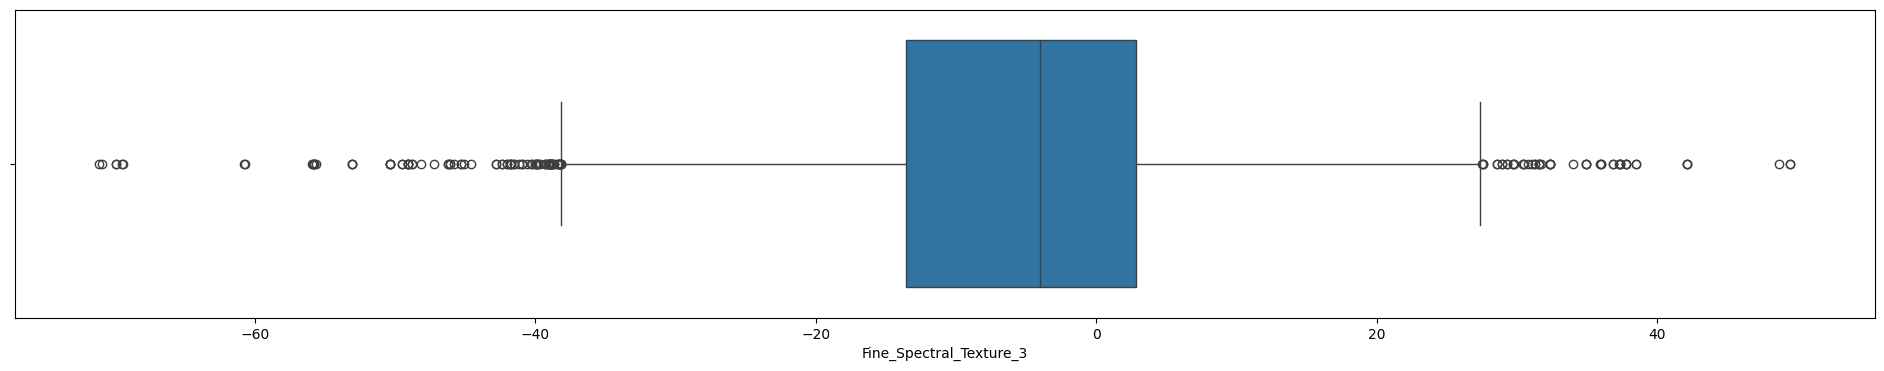

In [102]:
# Assuming 'metadata' is your DataFrame and it contains a 'Fine_Spectral_Texture_3' column
f = plt.figure(figsize=(24, 4))
sb.boxplot(data=metadata['Fine_Spectral_Texture_3'], orient="h")
plt.show()

# Boxplot analysis of Zero_Crossing_Rate

This feature measures the rate at which the audio signal changes sign, indicating how quickly it crosses the zero amplitude line. It's useful for estimating pitch and detecting percussive sounds, as it reflects the frequency of oscillation or the rhythmic patterns present in the signal. For example, it might help identify the rhythmic chirping of crickets or the repetitive calls of certain bird species.

For example,the rapid chirping or singing of birds often exhibits high zero-crossing rates due to the quick changes in amplitude between individual bird calls. Each chirp or tweet corresponds to a rapid fluctuation in the audio signal, resulting in a high rate of zero crossings.

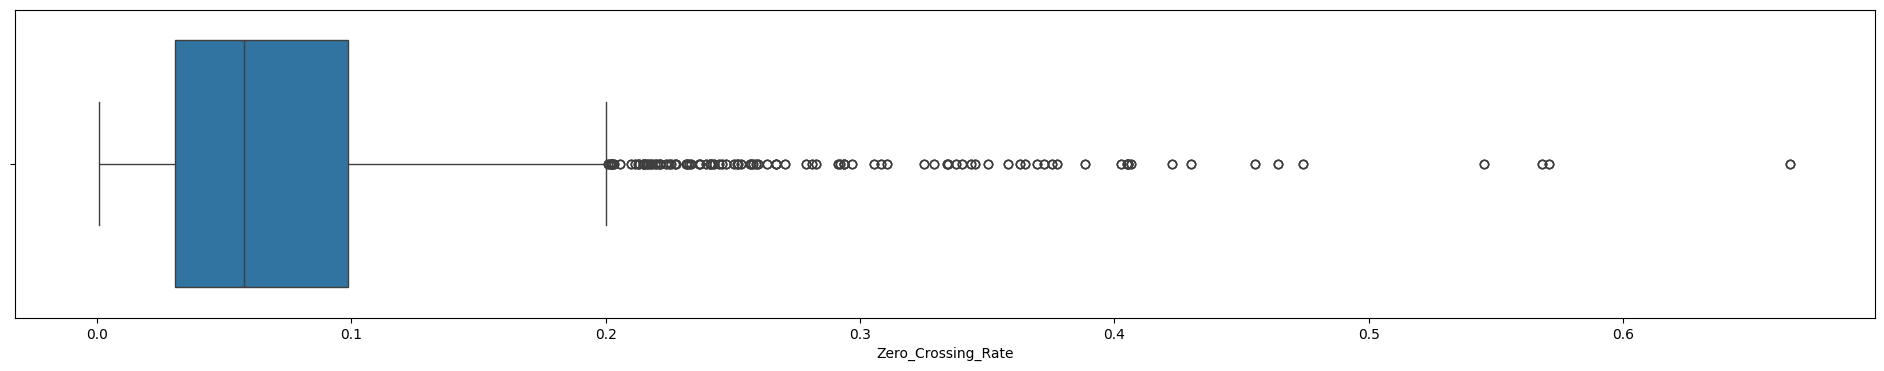

In [103]:
# Assuming 'metadata' is your DataFrame and it contains a 'Zero_Crossing_Rate' column
f = plt.figure(figsize=(24, 4))
sb.boxplot(data=metadata['Zero_Crossing_Rate'], orient="h")
plt.show()

# Boxplot analysis of Spectral_Centroid

This feature represents the "center of mass" of the frequency distribution, indicating where most of the energy in the spectrum is concentrated. It's often correlated with perceived brightness or pitch in auditory perception. Spectral centroid can provide valuable information about the overall tonal characteristics of the sound, aiding in the classification of animal calls or environmental sounds based on their spectral centroids.

A high correlation with spectral centroid suggests that the distribution of energy in the frequency spectrum, particularly where it's concentrated, is closely tied to the characteristic being studied.

For example, if a certain type of bird call has a high correlation with spectral centroid, it implies that the pitch or perceived brightness of the bird's call is closely related to its species. For example, the high-pitched chirps of a canary might have a distinct spectral centroid compared to the lower, throaty calls of a crow.

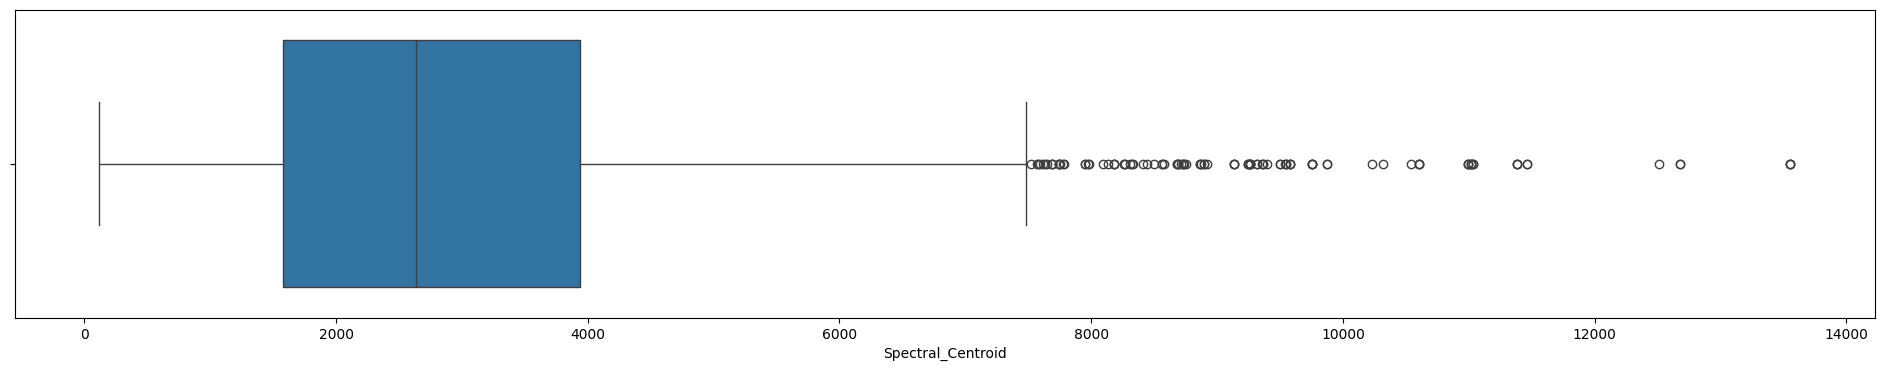

In [104]:
# Assuming 'metadata' is your DataFrame and it contains a 'Spectral_Centroid' column
f = plt.figure(figsize=(24, 4))
sb.boxplot(data=metadata['Spectral_Centroid'], orient="h")
plt.show()

In [105]:
# # Changing all non-animal category to the same name
# non_animal = metadata.copy()
# non_animal_mask = ~non_animal['category'].isin(animal_categories)
# non_animal.loc[non_animal_mask, 'category'] = 'non-animal'

# # Training AI to identify whether the sound is made by an animal and what type of animal it is from the important categories
# X = non_animal[important_features_2]  # Feature matrix
# y = non_animal['category']  # Original labels

# # Initialize and fit the label encoder
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)  # Transform labels to numerical values

# # Correctly split the data into training and testing sets using encoded labels
# X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.2, random_state=50)

# # Initialize the XGBoost classifier
# model = xgb.XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', use_label_encoder=False)

# # Train the model using encoded labels
# model.fit(X_train, y_train_encoded)

# # Make predictions on the test set
# y_pred = model.predict(X_test)

# # Calculate the accuracy using the encoded test labels
# accuracy = accuracy_score(y_test_encoded, y_pred)
# print(f"Accuracy: {accuracy * 100:.2f}%")

In [106]:
X = animal_metadata[feature_names]  # Feature matrix
y = animal_metadata['category']  # Original labels

# Initialize and fit the label encoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Transform labels to numerical values

# Correctly split the data into training and testing sets using encoded labels
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.2, random_state=50)

# Initialize the XGBoost classifier
model = xgb.XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', use_label_encoder=False)

# Train the model using encoded labels
model.fit(X_train, y_train_encoded)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the accuracy using the encoded test labels
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 98.11%
